In [63]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np

In [64]:
import SimpleITK as sitk

In [65]:
seg_path = '/mnt/nfs/home/liglesias/data_acdc/masks_training/patient001_frame01_gt.nii.gz'

In [66]:
sitk_seg = sitk.ReadImage(seg_path)

NiftiImageIO (0x14b4c9130): /mnt/nfs/home/liglesias/data_acdc/masks_training/patient001_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x14b4c9130): /mnt/nfs/home/liglesias/data_acdc/masks_training/patient001_frame01_gt.nii.gz has unexpected scales in sform



In [67]:
sitk_seg.GetSpacing()

(1.5625, 1.5625, 10.0)

In [68]:
seg_array = sitk.GetArrayFromImage(sitk_seg)
seg_array.shape

(10, 256, 216)

In [69]:
new_seg_array = seg_array.copy()
new_seg_array[new_seg_array == 3] = 4
new_seg_array.shape

(10, 256, 216)

In [70]:
new_sitk_seg = sitk.GetImageFromArray(new_seg_array)

In [71]:
new_sitk_seg.CopyInformation(sitk_seg)

In [72]:
# sitk.WriteImage(new_sitk_seg, '/mnt/nfs/home/liglesias/data_acdc/masks_training/patient001_frame01_gt_modified.nii.gz', useCompression=True)

In [73]:
root_dir = '/mnt/nfs/home/liglesias/data_acdc'

training_dir = os.path.join(root_dir, "masks_training")
testing_dir = os.path.join(root_dir, "masks_testing")

assert os.path.exists(training_dir), f"El directorio {training_dir} no existe"
assert os.path.exists(testing_dir), f"El directorio {testing_dir} no existe"

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)

print(f"Se encontraron {len(training_files)} archivos en {training_dir}")
print(f"Se encontraron {len(testing_files)} archivos en {testing_dir}")

Se encontraron 200 archivos en /mnt/nfs/home/liglesias/data_acdc/masks_training
Se encontraron 100 archivos en /mnt/nfs/home/liglesias/data_acdc/masks_testing


(216, 256, 10)
(232, 256, 10)
(232, 256, 10)
(256, 256, 10)
(232, 256, 10)


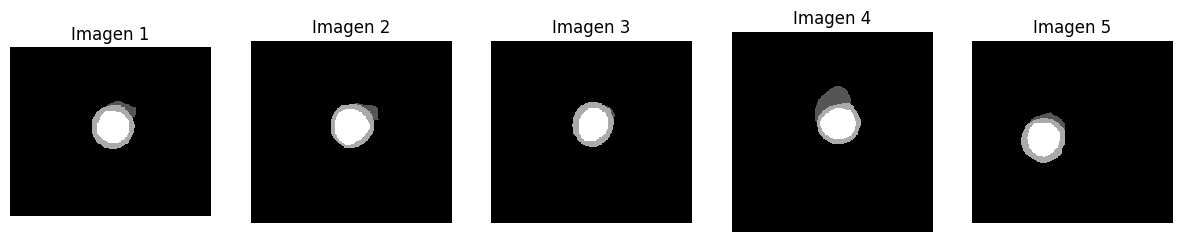

In [74]:
images = [nib.load(file).get_fdata() for file in training_files[:5]] 
fig, axs = plt.subplots(1, len(images), figsize=(15, 5))

for i, img in enumerate(images):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

In [75]:
all_files = training_files + testing_files
images = [nib.load(file).get_fdata() for file in all_files]
image_shapes = [img.shape for img in images]
print(image_shapes)
average_shape = np.mean(image_shapes, axis=0).astype(int)
print(f"Tamaño promedio: {average_shape}")
min_shape = np.min(image_shapes, axis=0)
max_shape = np.max(image_shapes, axis=0)

print(len(all_files))
print(f"Tamaño mínimo: {min_shape}")
print(f"Tamaño máximo: {max_shape}")

[(216, 256, 10), (232, 256, 10), (232, 256, 10), (256, 256, 10), (232, 256, 10), (256, 216, 10), (256, 216, 10), (232, 256, 11), (222, 224, 10), (222, 224, 10), (200, 256, 10), (208, 256, 10), (208, 256, 10), (184, 256, 10), (184, 256, 10), (216, 256, 10), (256, 216, 10), (256, 216, 10), (256, 216, 9), (216, 256, 9), (216, 256, 8), (208, 256, 8), (200, 256, 7), (200, 256, 7), (216, 256, 9), (216, 256, 9), (208, 256, 8), (208, 256, 8), (256, 256, 9), (216, 256, 10), (216, 256, 10), (224, 256, 10), (216, 256, 10), (216, 256, 10), (216, 256, 10), (240, 256, 10), (216, 256, 10), (216, 256, 10), (224, 256, 10), (208, 256, 13), (216, 256, 8), (216, 256, 7), (276, 384, 8), (276, 384, 8), (208, 256, 9), (208, 256, 10), (154, 224, 6), (232, 256, 9), (208, 256, 8), (208, 256, 8), (256, 216, 9), (256, 208, 9), (256, 208, 9), (256, 216, 7), (224, 256, 10), (216, 256, 8), (216, 256, 7), (428, 512, 8), (216, 256, 9), (216, 256, 9), (256, 216, 9), (216, 256, 9), (216, 256, 9), (256, 216, 10), (210, 2

In [76]:
# LINE ADDITION
def add_line_to_image(image, line_position=None, line_thickness=2):
    # Crear una copia de la imagen para no modificar la original
    image_with_line = image.copy()
    
    # Si no se especifica la posición de la línea, usar el centro de la máscara
    if line_position is None:
        # Calcular el rango de la máscara (donde los valores no son cero)
        mask_indices = np.where(image > 0)
        if len(mask_indices[0]) == 0:  # No hay máscara en la imagen
            return image_with_line
        line_position = (mask_indices[0].min() + mask_indices[0].max()) // 2  # Centro de la máscara

    # Aplicar la línea únicamente en los píxeles de la máscara
    start = max(0, line_position - line_thickness // 2)
    end = min(image.shape[0], line_position + line_thickness // 2)
    mask_region = image[start:end, :] > 0  # Determinar la región dentro de la máscara
    image_with_line[start:end, :][mask_region] = 1  # Añadir la línea solo dentro de la máscara
    return image_with_line

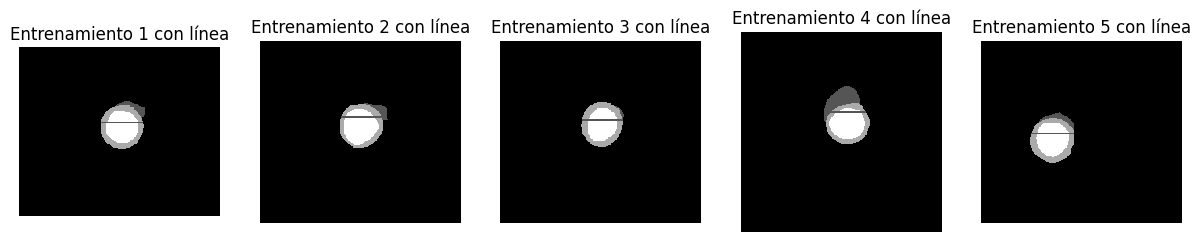

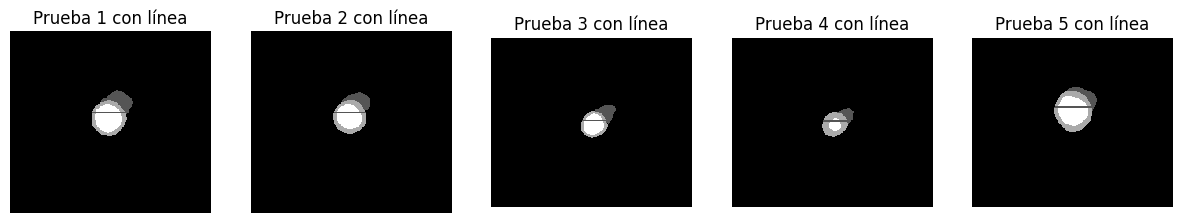

In [77]:
training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)

training_images =  [nib.load(file) for file in training_files]
testing_images = [nib.load(file) for file in testing_files]

training_images_data = [file.get_fdata() for file in training_images]
testing_images_data = [file.get_fdata() for file in testing_images]

training_images_with_line = [add_line_to_image(img) for img in training_images_data]
testing_images_with_line = [add_line_to_image(img) for img in testing_images_data]

fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i, img in enumerate(training_images_with_line[:5]):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none')
    axs[i].axis("off")
    axs[i].set_title(f"Entrenamiento {i+1} con línea")
    #print(img.shape)
plt.show()

fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i, img in enumerate(testing_images_with_line[:5]):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none')
    axs[i].axis("off")
    axs[i].set_title(f"Prueba {i+1} con línea")
    #print(img.shape)
plt.show()

In [103]:
training_output_dir = '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise'
testing_output_dir = '/mnt/nfs/home/liglesias/data_acdc/masks_testing_noise'

os.makedirs(training_output_dir, exist_ok=True)
os.makedirs(testing_output_dir, exist_ok=True)

def save_images_with_line(images, new_data, output_dir, file_names):
    for img, new_data, file_name in zip(images, new_data, file_names):
        nifti_img = nib.Nifti1Image(new_data, img.affine, img.header)
        output_path = os.path.join(output_dir, os.path.basename(file_name))
        nib.save(nifti_img, output_path)
        print(f"Imagen guardada en {output_path}")

save_images_with_line(training_images, training_images_with_line, training_output_dir, training_files)
save_images_with_line(testing_images, testing_images_with_line, testing_output_dir, testing_files)

Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient001_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient003_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient004_frame15_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame13_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient006_frame16_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient007_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise

In [99]:
training_files = list_nifti_files(training_dir)
print(training_dir)

training_path = training_files[0]
print(training_path)

image = nib.load(training_path)
print(type(image))

image_data = image.get_fdata()  # Los datos como array de NumPy
affine = image.affine  # La matriz affine

nifti_img = nib.Nifti1Image(image_data, affine, image.header)
nib.save(nifti_img, "/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/test.nii.gz")


/mnt/nfs/home/liglesias/data_acdc/masks_training
/mnt/nfs/home/liglesias/data_acdc/masks_training/patient001_frame12_gt.nii.gz
<class 'nibabel.nifti1.Nifti1Image'>


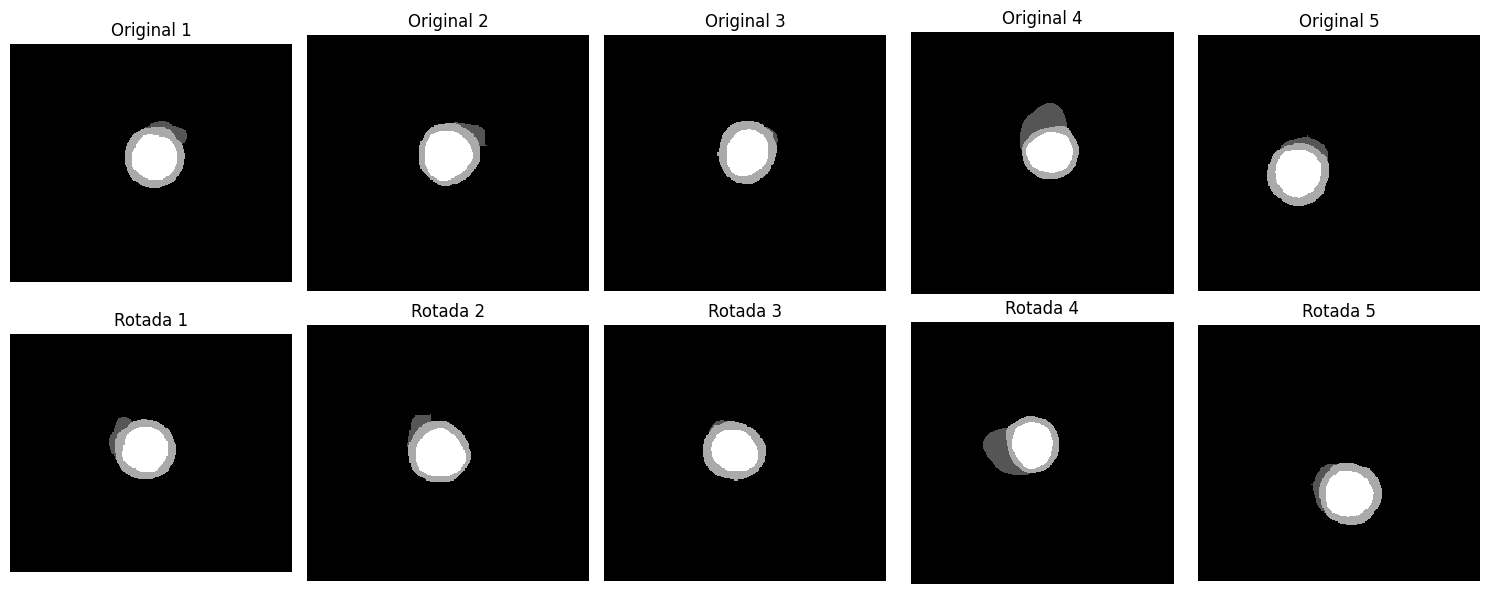

In [78]:
# ROTATION
from scipy.ndimage import rotate

def rotate_nifti_image(img_data, angle, axes=(0, 1)):
    rotated_img = np.zeros_like(img_data, dtype=np.float32)
    for i in range(img_data.shape[2]):
        rotated_img[:, :, i] = rotate(img_data[:, :, i], angle, axes=axes, reshape=False, order=1, mode='constant', cval=0)
    return rotated_img

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

angle = 90 

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)

training_images =  [nib.load(file) for file in training_files]
testing_images = [nib.load(file) for file in testing_files]

training_images_data = [file.get_fdata() for file in training_images]
testing_images_data = [file.get_fdata() for file in testing_images]

rotated_training_images = [rotate_nifti_image(nib.load(file).get_fdata(), angle=angle) for file in training_files]
rotated_testing_images = [rotate_nifti_image(nib.load(file).get_fdata(), angle=angle) for file in testing_files]

# Solo imprimo 5 de training
n_images_to_show = 5
fig, axs = plt.subplots(2, n_images_to_show, figsize=(15, 6))

for i, file in enumerate(training_files[:n_images_to_show]):
    img_data = nib.load(file).get_fdata()
    axs[0, i].imshow(img_data[:, :, img_data.shape[2] // 2], cmap="gray", interpolation='none')
    axs[0, i].axis("off")
    axs[0, i].set_title(f"Original {i+1}")

for i, img in enumerate(rotated_training_images[:n_images_to_show]):
    axs[1, i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none')
    axs[1, i].axis("off")
    axs[1, i].set_title(f"Rotada {i+1}")

plt.tight_layout()
plt.show()

In [ ]:
training_output_dir = '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise'
testing_output_dir = '/mnt/nfs/home/liglesias/data_acdc/masks_testing_noise'

os.makedirs(training_output_dir, exist_ok=True)
os.makedirs(testing_output_dir, exist_ok=True)

def save_images(images, new_data, output_dir, file_names):
    for img, new_data, file_name in zip(images, new_data, file_names):
        nifti_img = nib.Nifti1Image(new_data, img.affine, img.header)
        output_path = os.path.join(output_dir, os.path.basename(file_name))
        nib.save(nifti_img, output_path)
        print(f"Imagen guardada en {output_path}")

save_images(training_images, rotated_training_images, training_output_dir, training_files)
save_images(testing_images, rotated_testing_images, testing_output_dir, testing_files)

Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient001_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient003_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient004_frame15_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame13_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient006_frame16_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient007_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise

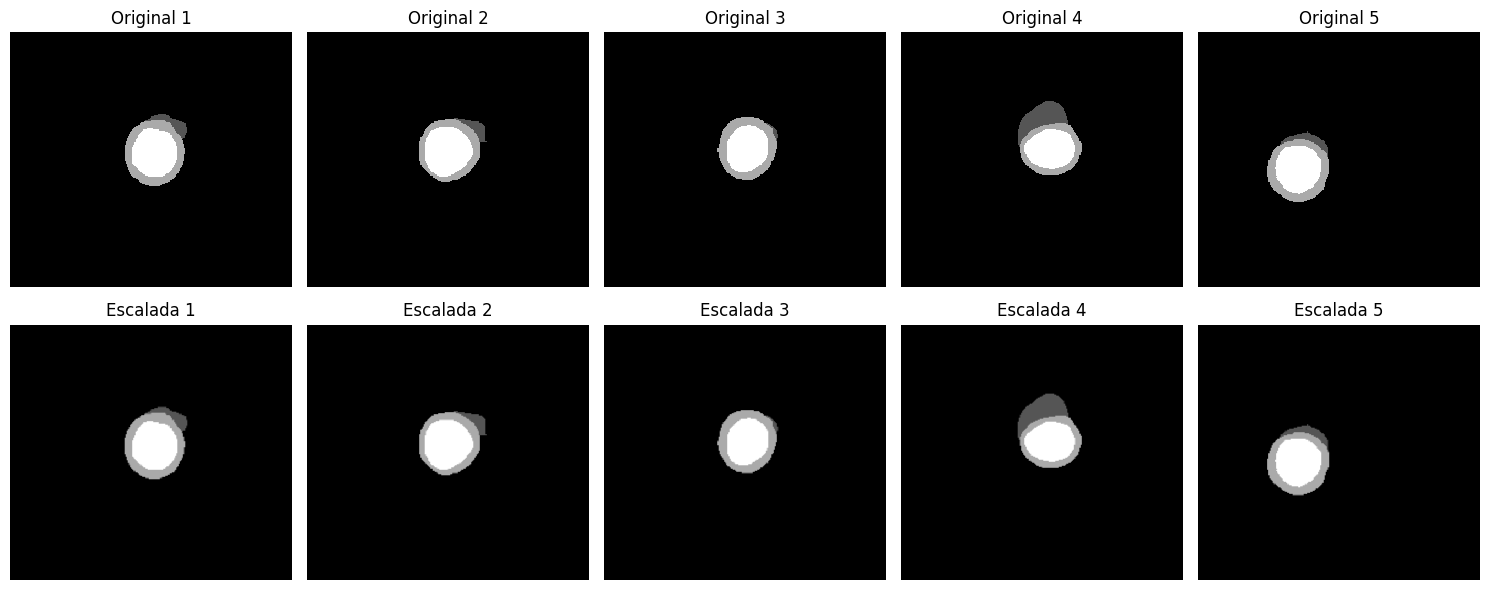

In [28]:
# RESIZE (NO FUNCIONA BIEN)
from scipy.ndimage import zoom

def resize_nifti_image(img_data, scale_factors):
    resized_img = zoom(img_data, scale_factors, order=1, mode='constant', cval=0)
    return resized_img

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

scale_factors = (2.0, 2.0, 1.0)  # Aumenta al doble en X e Y, mantiene Z igual

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)

training_images =  [nib.load(file) for file in training_files]
testing_images = [nib.load(file) for file in testing_files]

training_images_data = [file.get_fdata() for file in training_images]
testing_images_data = [file.get_fdata() for file in testing_images]

resized_training_images = [resize_nifti_image(nib.load(file).get_fdata(), scale_factors=scale_factors) for file in training_files]
resized_testing_images = [resize_nifti_image(nib.load(file).get_fdata(), scale_factors=scale_factors) for file in testing_files]

# Solo imprimo 5 de training
n_images_to_show = 5
fig, axs = plt.subplots(2, n_images_to_show, figsize=(15, 6))

for i, file in enumerate(training_files[:n_images_to_show]):
    img_data = nib.load(file).get_fdata()
    axs[0, i].imshow(img_data[:, :, img_data.shape[2] // 2], cmap="gray", interpolation='none', aspect='auto')
    axs[0, i].axis("off")
    axs[0, i].set_title(f"Original {i+1}")

for i, img in enumerate(resized_training_images[:n_images_to_show]):
    axs[1, i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none', aspect='auto')
    axs[1, i].axis("off")
    axs[1, i].set_title(f"Escalada {i+1}")

plt.tight_layout()
plt.show()

In [29]:
for i, file in enumerate(training_files[:n_images_to_show]):
    img_data = nib.load(file).get_fdata()
    resized_img = resize_nifti_image(img_data, scale_factors)
    print(f"Imagen {i+1} - Forma original: {img_data.shape}, Forma escalada: {resized_img.shape}")


Imagen 1 - Forma original: (216, 256, 10), Forma escalada: (432, 512, 10)
Imagen 2 - Forma original: (232, 256, 10), Forma escalada: (464, 512, 10)
Imagen 3 - Forma original: (232, 256, 10), Forma escalada: (464, 512, 10)
Imagen 4 - Forma original: (256, 256, 10), Forma escalada: (512, 512, 10)
Imagen 5 - Forma original: (232, 256, 10), Forma escalada: (464, 512, 10)


In [30]:
training_output_dir = '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise'
testing_output_dir = '/mnt/nfs/home/liglesias/data_acdc/masks_testing_noise'

os.makedirs(training_output_dir, exist_ok=True)
os.makedirs(testing_output_dir, exist_ok=True)

def save_images(images, new_data, output_dir, file_names):
    for img, new_data, file_name in zip(images, new_data, file_names):
        nifti_img = nib.Nifti1Image(new_data, img.affine, img.header)
        output_path = os.path.join(output_dir, os.path.basename(file_name))
        nib.save(nifti_img, output_path)
        print(f"Imagen guardada en {output_path}")

save_images(training_images, resized_training_images, training_output_dir, training_files)
save_images(testing_images, resized_testing_images, testing_output_dir, testing_files)

Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient001_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient003_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient004_frame15_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame13_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient006_frame16_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient007_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise

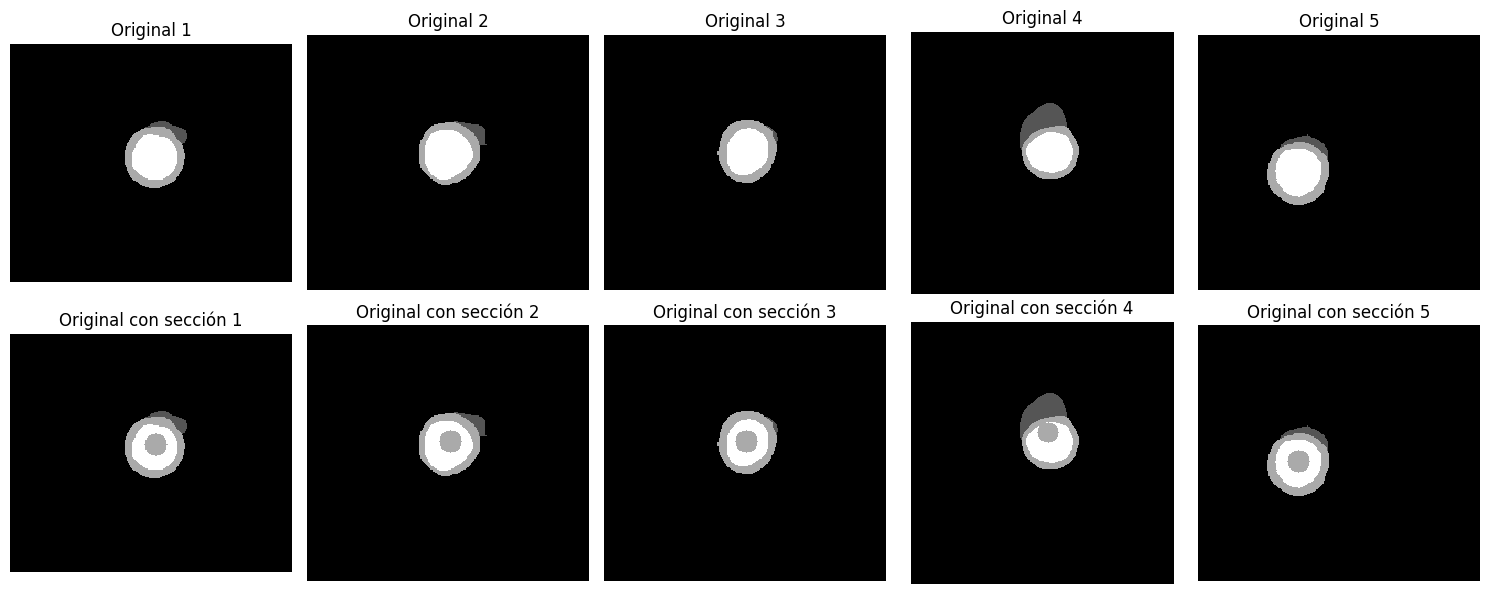

In [83]:
# SECTION ADDITION
import cv2
import nibabel as nib

def add_section_to_nifti_image(img_data, shape='circle', size=10):
    modified_img = img_data.copy()
    height, width, depth = img_data.shape

    for i in range(depth):
        mask = img_data[:, :, i].copy()
        
        coords = np.argwhere(mask > 0)
        if coords.size > 0:
            center_y, center_x = np.mean(coords, axis=0).astype(int)
            if shape == 'circle':
                cv2.circle(mask, (center_x, center_y), size, 2, -1)
            else:
                raise ValueError("Forma no soportada.")
            modified_img[:, :, i] = mask
    return modified_img

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)

training_images = [nib.load(file) for file in training_files]
testing_images = [nib.load(file) for file in testing_files]

training_images_data = [file.get_fdata() for file in training_images]
testing_images_data = [file.get_fdata() for file in testing_images]

section_training_images = [add_section_to_nifti_image(nib.load(file).get_fdata()) for file in training_files]
section_testing_images = [add_section_to_nifti_image(nib.load(file).get_fdata()) for file in testing_files]

n_images_to_show = 5
fig, axs = plt.subplots(2, n_images_to_show, figsize=(15, 6))

for i, file in enumerate(training_files[:n_images_to_show]):
    img_data = nib.load(file).get_fdata()
    axs[0, i].imshow(img_data[:, :, img_data.shape[2] // 2], cmap="gray", interpolation='none')
    axs[0, i].axis("off")
    axs[0, i].set_title(f"Original {i+1}")

for i, img in enumerate(section_training_images[:n_images_to_show]):
    axs[1, i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none')
    axs[1, i].axis("off")
    axs[1, i].set_title(f"Original con sección {i+1}")

plt.tight_layout()
plt.show()

In [84]:
training_output_dir = '/mnt/nfs/home/liglesias/masks_training_circle'
testing_output_dir = '/mnt/nfs/home/liglesias/masks_testing_circle'

os.makedirs(training_output_dir, exist_ok=True)
os.makedirs(testing_output_dir, exist_ok=True)

def save_images(images, new_data, output_dir, file_names):
    for img, new_data, file_name in zip(images, new_data, file_names):
        nifti_img = nib.Nifti1Image(new_data, img.affine, img.header)
        output_path = os.path.join(output_dir, os.path.basename(file_name))
        nib.save(nifti_img, output_path)
        print(f"Imagen guardada en {output_path}")

save_images(training_images, section_training_images, training_output_dir, training_files)
save_images(testing_images, section_testing_images, testing_output_dir, testing_files)

Imagen guardada en /mnt/nfs/home/liglesias/masks_raining_cicle/patient001_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/masks_raining_cicle/patient002_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/masks_raining_cicle/patient002_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/masks_raining_cicle/patient003_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/masks_raining_cicle/patient004_frame15_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/masks_raining_cicle/patient005_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/masks_raining_cicle/patient005_frame13_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/masks_raining_cicle/patient006_frame16_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/masks_raining_cicle/patient007_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/masks_raining_cicle/patient007_frame07_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/masks_raining_cicle/patient008_frame0

In [46]:
training_output_dir = '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise'
testing_output_dir = '/mnt/nfs/home/liglesias/data_acdc/masks_testing_noise'

os.makedirs(training_output_dir, exist_ok=True)
os.makedirs(testing_output_dir, exist_ok=True)

def save_images(images, new_data, output_dir, file_names):
    for img, new_data, file_name in zip(images, new_data, file_names):
        nifti_img = nib.Nifti1Image(new_data, img.affine, img.header)
        output_path = os.path.join(output_dir, os.path.basename(file_name))
        nib.save(nifti_img, output_path)
        print(f"Imagen guardada en {output_path}")

save_images(training_images, section_training_images, training_output_dir, training_files)
save_images(testing_images, section_testing_images, testing_output_dir, testing_files)

Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient001_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient003_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient004_frame15_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame13_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient006_frame16_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient007_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise

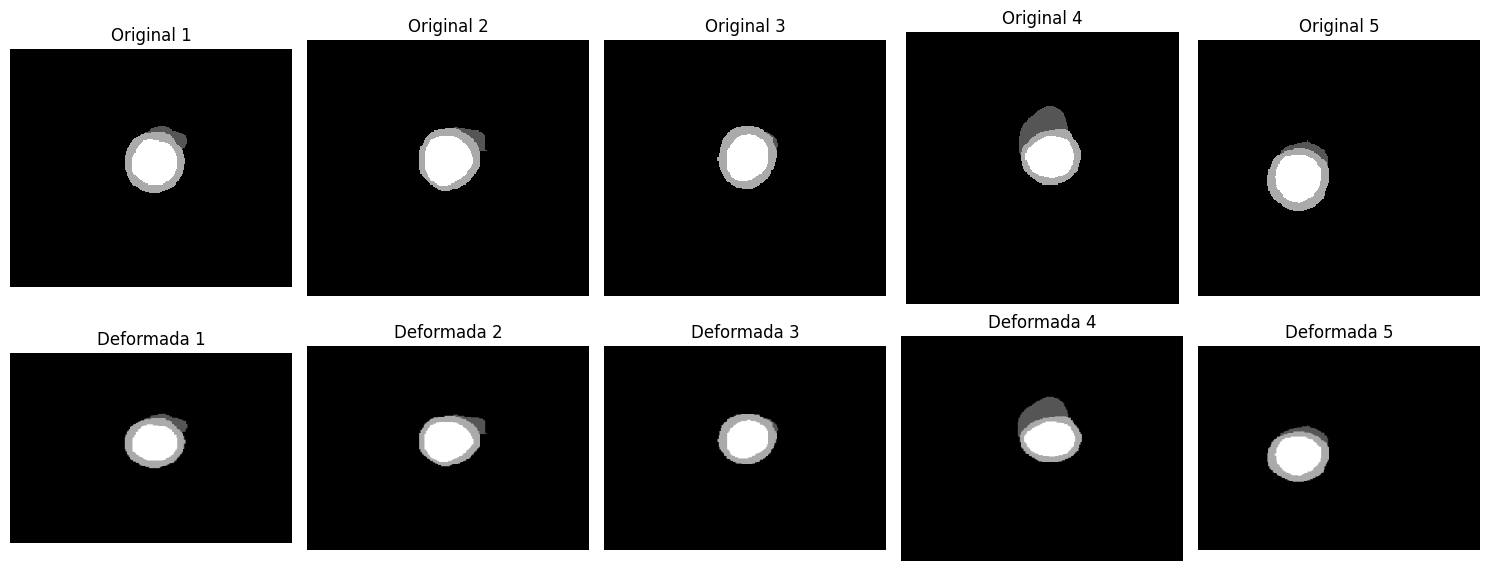

In [56]:
# DEFORMATION
from scipy.ndimage import zoom

def deform_nifti_image(img_data, scale_x=1.0, scale_y=1.0):
    deformed_slices = []
    zoom_factors = (scale_y, scale_x) 

    for i in range(img_data.shape[2]): 
        deformed_slice = zoom(
            img_data[:, :, i],
            zoom_factors,
            order=1,
            mode="constant",
            cval=0 
        )
        deformed_slices.append(deformed_slice)

    deformed_img = np.stack(deformed_slices, axis=2)
    return deformed_img

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

scale_x = 1.5  
scale_y = 1.2 

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)

deformed_training_images = [
    deform_nifti_image(nib.load(file).get_fdata(), scale_x=scale_x, scale_y=scale_y)
    for file in training_files
]
deformed_testing_images = [
    deform_nifti_image(nib.load(file).get_fdata(), scale_x=scale_x, scale_y=scale_y)
    for file in testing_files
]

n_images_to_show = 5
fig, axs = plt.subplots(2, n_images_to_show, figsize=(15, 6))

for i, file in enumerate(training_files[:n_images_to_show]):
    img_data = nib.load(file).get_fdata()
    axs[0, i].imshow(img_data[:, :, img_data.shape[2] // 2], cmap="gray", interpolation="none")
    axs[0, i].axis("off")
    axs[0, i].set_title(f"Original {i+1}")

for i, img in enumerate(deformed_training_images[:n_images_to_show]):
    axs[1, i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation="none")
    axs[1, i].axis("off")
    axs[1, i].set_title(f"Deformada {i+1}")

plt.tight_layout()
plt.show()

In [20]:
training_output_dir = '/mnt/nfs/home/liglesias/data_acdc/training_deformation'
testing_output_dir = '/mnt/nfs/home/liglesias/data_acdc/testing_deformation'

os.makedirs(training_output_dir, exist_ok=True)
os.makedirs(testing_output_dir, exist_ok=True)

def save_images(images, new_data, output_dir, file_names):
    for img, new_data, file_name in zip(images, new_data, file_names):
        nifti_img = nib.Nifti1Image(new_data, img.affine, img.header)
        output_path = os.path.join(output_dir, os.path.basename(file_name))
        nib.save(nifti_img, output_path)
        print(f"Imagen guardada en {output_path}")

save_images(training_images, deformed_training_images, training_output_dir, training_files)
save_images(testing_images, deformed_testing_images, testing_output_dir, testing_files)

Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/training_deformation/patient001_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/training_deformation/patient002_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/training_deformation/patient002_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/training_deformation/patient003_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/training_deformation/patient004_frame15_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/training_deformation/patient005_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/training_deformation/patient005_frame13_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/training_deformation/patient006_frame16_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/training_deformation/patient007_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/training_deformation